In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
import os
import random
import keras_tuner as kt
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow import math

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# read csv file
insurance_df = pd.read_csv("Insurance_claims.csv")
# insurance_df.head()
insurance_df = insurance_df.drop(
    ["ReferenceId", "PolicyholderNumber", "InsurerNotes"], axis=1
)
# these are unique values which should be dropped and column about postcode and date will be dropped later
# we need to find those repeated values and set them into 1, others into 0(including the missing value)
mask = insurance_df["FirstPartyVehicleNumber"].duplicated()
insurance_df.loc[mask, "FirstPartyVehicleNumber"] = 1
insurance_df.loc[~mask, "FirstPartyVehicleNumber"] = 0


# check if there is thirdpartyvehicle, yes -> 1, no -> 0
insurance_df["ThirdPartyVehicleNumber"].fillna(0)
insurance_df["ThirdPartyVehicleNumber"] = insurance_df["ThirdPartyVehicleNumber"].apply(
    lambda x: 1 if x > 0 else 0
)
insurance_df["LossDate"] = pd.to_datetime(insurance_df["LossDate"])
insurance_df["FirstPolicySubscriptionDate"] = pd.to_datetime(
    insurance_df["FirstPolicySubscriptionDate"]
)

# calculate the number of days between the two dates
insurance_df["days_between"] = insurance_df.apply(
    lambda row: (row["LossDate"] - row["FirstPolicySubscriptionDate"]).days, axis=1
)
insurance_df = insurance_df.drop(["LossDate", "FirstPolicySubscriptionDate"], axis=1)
# check the two postcodes
def compare_digits(x, y):
    x_len = len(str(x))
    y_len = len(str(y))
    if x_len == y_len:
        if x_len == 5:
            return str(x)[:2] == str(y)[:2]
        elif x_len == 4:
            return str(x)[0] == str(y)[0]
        else:
            return False
    else:
        return False


# check if the loss place is in the same district of the holder's place
insurance_df["IfinSameArea"] = insurance_df.apply(
    lambda row: 1
    if compare_digits(row["LossPostCode"], row["PolicyHolderPostCode"])
    else 0,
    axis=1,
)
insurance_df = insurance_df.drop(["LossPostCode", "PolicyHolderPostCode"], axis=1)
# set these columns to dummies
insurance_df = pd.get_dummies(
    insurance_df,
    columns=[
        "PolicyholderOccupation",
        "ClaimCause",
        "ClaimInvolvedCovers",
        "FirstPartyVehicleType",
        "ConnectionBetweenParties",
    ],
)

# check the two postcodes
def jud(x):
    if x == "TotalLoss":
        return 2
    elif x == "Medium":
        return 1
    else:
        return 0


insurance_df["DamageImportance"] = insurance_df["DamageImportance"].fillna(0)
insurance_df["DamageImportance"] = insurance_df["DamageImportance"].apply(
    lambda row: jud(row)
)

mean_v_fp = insurance_df["FpVehicleAgeMonths"].mean()
insurance_df["FpVehicleAgeMonths"] = insurance_df["FpVehicleAgeMonths"].fillna(
    value=mean_v_fp
)

insurance_df["LossHour"] = insurance_df["LossHour"].fillna(
    insurance_df["LossHour"].mean()
)
mean_v_po = insurance_df["PolicyHolderAge"].mean()
insurance_df["PolicyHolderAge"] = insurance_df["PolicyHolderAge"].fillna(mean_v_po)

# insurance_df["weight"] = insurance_df["Fraud"].apply(lambda x : 2 if x == 1 else 0)

In [3]:
y = insurance_df["Fraud"]  # creating the dependent variable
X = insurance_df.drop(columns=["Fraud"])


X_train, X_other, Y_train, Y_other = train_test_split(
    X, y, train_size=0.7, random_state=111
)

X_test, X_valid, Y_test, Y_valid = train_test_split(
    X_other, Y_other, test_size=0.5, random_state=111
)

# norm_layer = tf.keras.layers.Normalization()
# norm_layer.adapt(insurance_df.iloc[:,-1])
# X_train_scaled = norm_layer(X_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [4]:
def train_model(hp):

    n_hiddens = hp.Int("n_hiddens", min_value=2, max_value=24, step=1)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=512, step=8)
    dropout_rate = hp.Float("dropout_rate", min_value=0.01, max_value=1, step=0.01)
    learning_rate = hp.Float(
        "learning_rate", min_value=0.001, max_value=0.1, sampling="log"
    )
    
    model = tf.keras.Sequential(
        [
        tf.keras.layers.Flatten(input_shape=(121, 1))]
    )

    for _ in range(n_hiddens):
        
        model.add(
            tf.keras.layers.Dense(
                n_neurons,
                # activation=hp.Choice("activation" + str(i), values=["relu", "tanh"]),
                kernel_initializer="uniform",
                use_bias=False,
                activation= tf.keras.layers.LeakyReLU(alpha=0.2),
                )
        )
        tf.keras.layers.BatchNormalization(),
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
        
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    optimizer = hp.Choice("optimizer", values=["adam", "rmsprop", "sgd"])

    if optimizer == "adam":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    METRICS = [
      tf.keras.metrics.MeanSquaredError(name='mse'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    model.compile(
        # optimizer=optimizer, loss="mean_squared_error", metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
        optimizer=optimizer, loss='binary_crossentropy',
                  metrics=METRICS
    )

    return model

In [5]:
def create_plot(log):
    plt.plot(log.history["accuracy"], label="training accuracy", color="red")
    plt.plot(log.history["loss"], label="training loss", color="darkgreen")
    plt.plot(
        log.history["val_accuracy"],
        label="validation accuracy",
        color="grey",
    )
    plt.plot(log.history["val_loss"], label="validation loss", color="darkblue")
    plt.legend()
    plt.show()

In [6]:
def opt_threshold(model):
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Calculate the F1 score for different threshold values
    f1_scores = []
    thresholds = np.arange(0.0, 1.0, 0.01)
    for threshold in thresholds:
        y_pred_thresh = tf.keras.backend.cast(y_pred > threshold, 'float32')
        f1 = f1_score(Y_test, y_pred_thresh)
        f1_scores.append(f1)

    # Select the threshold with the highest F1 score
    optimal_threshold = thresholds[np.argmax(f1_scores)]

    return optimal_threshold

In [7]:
neg, pos = np.bincount(insurance_df['Fraud'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 11530
    Positive: 115 (1.00% of total)

Weight for class 0: 0.51
Weight for class 1: 50.13


In [10]:
hyperband_tuner = kt.Hyperband(
    train_model,
    # objective=kt.Objective("rmse", direction="min"),
    objective='loss',
    max_epochs=5,
    factor=3,
    directory="logs_2",
    project_name="hb_tuner",
    
)

hyperband_tuner.search(X_train_scaled, Y_train, validation_data=(X_valid_scaled, Y_valid))
best_hps = hyperband_tuner.get_best_hyperparameters()[0]
best_hb_model = hyperband_tuner.hypermodel.build(best_hps)


Trial 13 Complete [00h 00m 37s]
loss: 4.40964412689209

Best loss So Far: 0.14338628947734833
Total elapsed time: 00h 02m 33s
INFO:tensorflow:Oracle triggered exit


Epoch 1/100
85/85 [==============================] - ETA: 0s - loss: 0.3105 - mse: 0.0967 - tp: 82.0000 - fp: 1011.0000 - tn: 6974.0000 - fn: 3.0000 - accuracy: 0.8743 - precision: 0.0750 - recall: 0.9647 - auc: 0.9481 - prc: 0.0983
Epoch 1: val_loss improved from inf to 0.36272, saving model to best_test_model.h1
85/85 [==============================] - 2s 26ms/step - loss: 0.3105 - mse: 0.0967 - tp: 82.0000 - fp: 1011.0000 - tn: 6974.0000 - fn: 3.0000 - accuracy: 0.8743 - precision: 0.0750 - recall: 0.9647 - auc: 0.9481 - prc: 0.0983 - val_loss: 0.3627 - val_mse: 0.0953 - val_tp: 11.0000 - val_fp: 216.0000 - val_tn: 1501.0000 - val_fn: 2.0000 - val_accuracy: 0.8740 - val_precision: 0.0485 - val_recall: 0.8462 - val_auc: 0.9079 - val_prc: 0.0413
Epoch 2/100
85/85 [==============================] - ETA: 0s - loss: 0.3113 - mse: 0.0994 - tp: 81.0000 - fp: 1077.0000 - tn: 6908.0000 - fn: 4.0000 - accuracy: 0.8660 - precision: 0.0699 - recall: 0.9529 - auc: 0.9463 - prc: 0.1031
Epoch 2: v

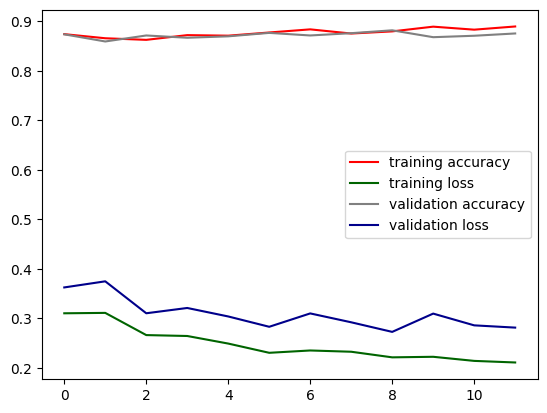

In [55]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, 
    restore_best_weights=True,
    mode = 'max'
)  

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_test_model.h1',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

log = best_hb_model.fit(
    X_train_scaled,
    Y_train,
    epochs=100,
    batch_size=96,
    validation_data=(X_valid_scaled, Y_valid),
    callbacks=[early_stopping_cb, checkpoint],
    class_weight = class_weight
)

create_plot(log)

In [58]:
y_pred = best_hb_model.predict(X_test_scaled)
y_pred = y_pred.ravel()

mse = np.sum((y_pred - Y_test) ** 2) / len(y_pred)
print("Mean square error: ", mse)

opt_thresh = opt_threshold(best_hb_model) 

y_pred = [1 if p > opt_thresh else 0 for p in y_pred]

hits = sum(Y_test & y_pred)

hit_rate = hits / np.sum(y_pred)
detection_rate = np.sum(y_pred) / len(y_pred)


print("Threshold-------------------------:", opt_thresh)
print("Number of data in testset:--------:", len(y_pred))
print("Number of predicted frauds--------:", np.sum(y_pred))
print("Total number of frauds in testset-:", np.sum(Y_test))
print("Number of predicted frauds hit----:", hits)
print("Hit rate--------------------------:", hit_rate)
print("Detection rate--------------------:", detection_rate)

55/55 [==============================] - 0s 2ms/step
Mean square error:  0.10106294164353678
55/55 [==============================] - 0s 2ms/step
Threshold-------------------------: 0.99
Number of data in testset:--------: 1730
Number of predicted frauds--------: 14
Total number of frauds in testset-: 17
Number of predicted frauds hit----: 3
Hit rate--------------------------: 0.21428571428571427
Detection rate--------------------: 0.008092485549132947


In [65]:
from keras.applications.vgg16 import VGG16

model = VGG16('best_test_model.h1', weights=None, input_shape=(121,1211,1))

y_pred = model.predict(X_test_scaled)
y_pred = y_pred.ravel()

mse = np.sum((y_pred - Y_test) ** 2) / len(y_pred)
print("Mean square error: ", mse)

opt_thresh = opt_threshold(best_hb_model) 

y_pred = [1 if p > opt_thresh else 0 for p in y_pred]

hits = sum(Y_test & y_pred)

hit_rate = hits / np.sum(y_pred)
detection_rate = np.sum(y_pred) / len(y_pred)


print("Threshold-------------------------:", opt_thresh)
print("Number of data in testset:--------:", len(y_pred))
print("Number of predicted frauds--------:", np.sum(y_pred))
print("Total number of frauds in testset-:", np.sum(Y_test))
print("Number of predicted frauds hit----:", hits)
print("Hit rate--------------------------:", hit_rate)
print("Detection rate--------------------:", detection_rate)

ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "vgg16" "                 f"(type Functional).
    
    Input 0 of layer "block1_conv1" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 121)
    
    Call arguments received by layer "vgg16" "                 f"(type Functional):
      • inputs=tf.Tensor(shape=(None, 121), dtype=float32)
      • training=False
      • mask=None
